In [1]:
import os
import numpy as np
import pandas as pd
import urllib.request
import zipfile
import gdown
import matplotlib.image as mpimg
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary

from torch.utils.data import Dataset, TensorDataset, DataLoader


In [2]:
class DRDataset(Dataset):
    def __init__(self, data_label, data_dir, transform):
        super().__init__()
        self.data_label = data_label
        self.data_dir = data_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data_label)

    def __getitem__(self, index):
        img_name = self.data_label.id_code[index] + '.png'
        label = self.data_label.diagnosis[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = mpimg.imread(img_path)
        image = (image + 1) * 127.5
        image = image.astype(np.uint8)
        image = self.transform(image)
        return image, label

In [3]:
# TODO: have a better way of setting this
DATA_LOADED = True
NUMPY_DIR = "NumpyData"
DEVICE = 'cpu'
BATCH_SIZE = 50
LR = 0.01
MAX_EPOCH = 300
# work out the story with iid
if DATA_LOADED:
    _x = torch.Tensor(np.load(os.path.join(NUMPY_DIR,"dr_train_images.npy")))
    _y = torch.Tensor(np.load(os.path.join(NUMPY_DIR,"dr_train_labels.npy"))).long()
    train_dataset = TensorDataset(_x,_y)
    _x = torch.Tensor(np.load(os.path.join(NUMPY_DIR,"dr_test_images.npy")))
    _y = torch.Tensor(np.load(os.path.join(NUMPY_DIR,"dr_test_labels.npy"))).long()
    test_dataset = TensorDataset(_x,_y)            

else:
    DATA_DIR = '../data/diabetic_retinopathy/'
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)

    #download ZIP, unzip it, delete zip file
    DATA_URL = "https://drive.google.com/uc?id=1G-4UhPKiQY3NxQtZiWuOkdocDTW6Bw0u"
    zip_path = DATA_DIR + 'images.zip'
    gdown.download(DATA_URL, zip_path, quiet=False)
    print("Extracting...!")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("Extracted!")
    os.remove(zip_path)

    #download train and test dataframes
    test_csv_link = 'https://drive.google.com/uc?id=1dmeYLURzEvx962th4lAxaVN3r6nlhTjS'
    train_csv_link = 'https://drive.google.com/uc?id=1SMb9CRHjB6UH2WnTZDFVSgpA6_nh75qN'
    test_csv_path = DATA_DIR + 'test_set.csv'
    train_csv_path = DATA_DIR + 'train_set.csv'
    urllib.request.urlretrieve(train_csv_link, train_csv_path)
    urllib.request.urlretrieve(test_csv_link, test_csv_path)
    df_train = pd.read_csv(train_csv_path)
    df_test = pd.read_csv(test_csv_path)

    #create train and test datasets
    apply_transform = transforms.Compose([transforms.ToPILImage(mode='RGB'),
                            transforms.RandomHorizontalFlip(),
                            transforms.Resize(265),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    image_directory = DATA_DIR + 'images/'
    train_dataset = DRDataset(data_label = df_train, data_dir = image_directory,
                                transform = apply_transform)
    test_dataset = DRDataset(data_label = df_test, data_dir = image_directory,
                                transform = apply_transform)

    print("train_dataset size:", len(train_dataset))
    print("test_dataset size:", len(test_dataset))
    # print("data shape:", train_dataset[0][0].shape)
    print("train")
    dr_images = []
    dr_labels = []
    for i in range(len(train_dataset)):        
        _image, _label = train_dataset[i]
        dr_images.append(_image.numpy())
        dr_labels.append(_label)
        print("  ", i, end="\r")
    print("")
    dr_images = np.array(dr_images)
    dr_labels = np.array(dr_labels)
    np.save(os.path.join(NUMPY_DIR,"dr_train_images.npy"), dr_images)
    np.save(os.path.join(NUMPY_DIR,"dr_train_labels.npy"), dr_labels)
    print("test")
    dr_images = []
    dr_labels = []
    for i in range(len(test_dataset)):        
        _image, _label = test_dataset[i]
        dr_images.append(_image.numpy())
        dr_labels.append(_label)
        print("  ", i, end="\r")
    print("")
    dr_images = np.array(dr_images)
    dr_labels = np.array(dr_labels)
    np.save(os.path.join(NUMPY_DIR,"dr_test_images.npy"), dr_images)
    np.save(os.path.join(NUMPY_DIR,"dr_test_labels.npy"), dr_labels)

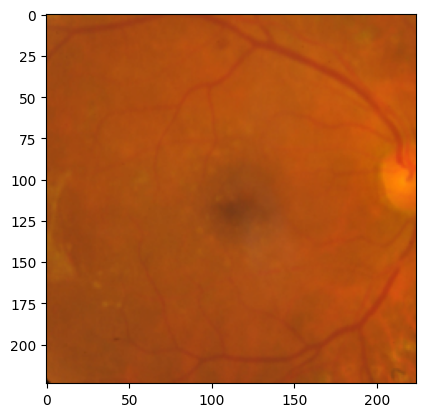

In [4]:
import matplotlib.pyplot as plt
#plt.imshow(  tensor_image.permute(1, 2, 0)  )
plt.imshow(train_dataset[0][0].permute(1,2,0))

In [5]:
# get data
#trainloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True, drop_last=True) 

# Split the dataset into training and validation sets
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
train_dataset

In [7]:
# Display the number of images in each class for both train and val datasets
print("Number of images in each class - Training Dataset:")
for class_idx in range(10):  # CIFAR-10 has 10 classes
    num_images = sum(1 for _, label in train_dataset if label == class_idx)
    print(f"Class {class_idx}: {num_images} images")

print("\nNumber of images in each class - Validation Dataset:")
for class_idx in range(10):
    num_images = sum(1 for _, label in val_dataset if label == class_idx)
    print(f"Class {class_idx}: {num_images} images")

Number of images in each class - Training Dataset:


Class 0: 1307 images
Class 1: 268 images
Class 2: 713 images
Class 3: 139 images
Class 4: 211 images
Class 5: 0 images
Class 6: 0 images
Class 7: 0 images
Class 8: 0 images
Class 9: 0 images

Number of images in each class - Validation Dataset:
Class 0: 137 images
Class 1: 28 images
Class 2: 87 images
Class 3: 16 images
Class 4: 25 images
Class 5: 0 images
Class 6: 0 images
Class 7: 0 images
Class 8: 0 images
Class 9: 0 images


In [8]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [9]:
global_model = models.squeezenet1_1(pretrained=True)           
global_model.classifier[1] = nn.Conv2d(512, 5, kernel_size=(1,1), stride=(1,1))
global_model.num_classes = 5
global_model.to(DEVICE)
summary(global_model, input_size=(3, 224, 224), device=DEVICE)

c:\git_repos\Thesis\flowerEnv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\git_repos\Thesis\flowerEnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [10]:
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(global_model.parameters(), lr=LR)

In [13]:
for i, data in enumerate(valloader):
    if i == 0:
        inputs, labels = data
        print(inputs.shape)

torch.Size([50, 3, 224, 224])


In [12]:
# Early stopping parameters
patience = 30
best_val_loss = float('inf')
counter = 0

epoch_loss = []

train_loss = []
val_loss = []
# Training loop
for epoch in range(MAX_EPOCH):  # You can adjust the number of epochs
    optimizer.zero_grad()
    global_model.train()
    running_loss = []
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        outputs = global_model(inputs)
        loss = criterion(outputs, labels)

        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        running_loss.append(loss.item())


    epoch_loss.append(sum(running_loss)/len(running_loss))
    loss_avg = sum(epoch_loss) / len(epoch_loss)        
    train_loss.append(loss_avg)

    print(f'Epoch {epoch + 1}, Training Loss: {train_loss[-1]}')

    # Validation loss calculation
    global_model.eval()
    loss, total, correct = 0.0, 0.0, 0.0
    with torch.no_grad():
        for data in enumerate(valloader):
            inputs, labels = data
            outputs = global_model(inputs)
            loss += criterion(outputs, labels).item()

            _, pred_labels = torch.max(outputs, 1)
            pred_labels = pred_labels.view(-1)
            correct += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)

    accuracy = correct/total
    loss = loss/total

    print(f'Epoch {epoch + 1}, Validation Loss: {loss:.3f}, Validation Accuracy: {accuracy:.3f}')

    # Check for early stopping
    if loss < best_val_loss:
        best_val_loss = loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping after {epoch + 1} epochs.')
            break

print('Finished Training')


Epoch 1, Training Loss: 10.249682649126592


TypeError: conv2d() received an invalid combination of arguments - got (int, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!int!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!int!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
